### 07-defensive_ml.ipynb

**Objective**: Develop a predictive model for defensive player fantasy picks. The model's quality will be assessed on the R^2 score of that player's 'Total Points'.  

**Approach**: Build separate models for attack-style players and stopping-style players since the metrics used to assess each group are inherently different.

**Output**: 
1. attack_results.csv (_defense_analysis/data/processed/attack_results.csv)
    * Stack ranked list of scoring attack style defensive players.
2. stopping_results.csv (_defense_analysis/data/processed/stopping_results.csv)
    * Stack ranked list of stout stopping style defensive players.
3. defender_results.csv (_defense_analysis/data/processed/defender_results.csv)
    * This is a merged list that is used for developing a Team 3 Score per player
4. FileName.scv Goes Here
    * extend the merged 'defender_results.csv' list for use integrating with player card visuals
------------------------------------------------------------------------------------------------------

 #### Set Up the Notebook

In [1187]:
# import libraries
import pandas as pd
import numpy as np

#import path
from pathlib import Path

# sklearn fun
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# visuals
import matplotlib.pyplot as plt


In [1188]:
# Define the base directory for the data files
base_directory = Path('../data/processed')

# Define file paths for attack and stopping style players
attack_style_filepath = base_directory / 'attack_style_players.csv'
stopping_style_filepath = base_directory / 'stopping_style_players.csv'

# Load datasets into DataFrames
attack_style_df = pd.read_csv(attack_style_filepath)
stopping_style_df = pd.read_csv(stopping_style_filepath)

# Display the first few rows of each DataFrame to confirm
print("Attack Style Players Data:")
print(attack_style_df.head(), "\n")

print("Stopping Style Players Data:")
print(stopping_style_df.head(), "\n")


Attack Style Players Data:
  second_name_defender  season_name  element_code  start_cost  end_cost  \
0               Aarons         2019        232980          45        42   
1           Adarabioyo         2020        109646          45        45   
2               Aguerd         2022        210494          50        48   
3                 Aina         2016        159506          50        45   
4                 Ajer         2021        191866          45        44   

   goals_scored  assists  minutes  clean_sheets  goals_conceded  ...  \
0             0        5     7352            11             175  ...   
1             3        1     6653            18             105  ...   
2             3        0     3451             7              72  ...   
3             3        2     4380            10              75  ...   
4             3        4     4584            17              79  ...   

        ACR       EAC        OII        OE         OAI          MOA  \
0  0.000680  0.022

### Data Preprocessing:


In [1189]:
#  Correlation Analysis from Notebook 06

#### From Attacking Style EDA
# #### Drop List for ML
# * OII (covered by OASIS)
# * OAI (covered by OASIS)
# * ACR (covered by OASIS)
# * expected_goals_conceded (keep expected_goal_involvements)
# * defensive_effectiveness (keep clean_sheets) -- double check 04 metrics
# * id_ref
# * end_cost


#### From Stopping Style EDA
# #### High Correlation Observations:
# * DSS (Defensive Stopping Score): Highly correlated with several other metrics, such as defensive effectiveness and clean sheets.  I will drop defensive effectiveness and clean sheets in an attempt to use DSS as a predictive target for this style of player
# * Goals Conceded per 90 and Expected Goals Conceded: These are closely tied to each other and also to the clean sheets and defensive effectiveness metrics. I will remove expected_goals_conceded.
# * Bonus and Total Points: These are fantasy league metrics and are often tied together. Since they're highly correlated, I will drop bonus and retain total_points.
# * Goals Conceded and Clean Sheets: It may be redundant to keep both and so will drop.
# * ID Reference (id_ref): The referee identifier is not typically necessary for player performance.
# * GPP90 (Goals Prevented per 90): It can be dropped since it's a summary of two metrics.

In [1190]:
#  Correlation Analysis from Notebook 06
#
##### From Attacking Style EDA
# ### Drop List for ML
# * OII (covered by OASIS)
# * OAI (covered by OASIS)
# * ACR (covered by OASIS)
# * expected_goals_conceded (keep expected_goal_involvements)
# * defensive_effectiveness (keep clean_sheets) -- double check 04 metrics
# * id_ref
# * end_cost


# Drop highly correlated columns from attack_style_df
attack_style_drop_columns = [
    'OII',  # Covered by OASIS
    'OAI',  # Covered by OASIS
    'ACR',  # Covered by OASIS
    'expected_goals_conceded',  # Keeping expected_goal_involvements
    'defensive_effectiveness',  # Keeping clean_sheets
    'id_ref',   # Not needed
    'end_cost'  # Not needed
]

# Drop the columns in attack_style_df
attack_style_df = attack_style_df.drop(columns=attack_style_drop_columns, errors='ignore')

In [1191]:
#  Correlation Analysis from Notebook 06
#
#### From Stopping Style EDA
# #### High Correlation Observations:
# * DSS (Defensive Stopping Score): Highly correlated with several other metrics, such as defensive effectiveness and clean sheets.  I will drop defensive effectiveness and clean sheets in an attempt to use DSS as a predictive target for this style of player
# * Goals Conceded per 90 and Expected Goals Conceded: These are closely tied to each other and also to the clean sheets and defensive effectiveness metrics. I will remove expected_goals_conceded.
# * Bonus and Total Points: These are fantasy league metrics and are often tied together. Since they're highly correlated, I will drop bonus and retain total_points.
# * Goals Conceded and Clean Sheets: It may be redundant to keep both and so will drop.
# * ID Reference (id_ref): The referee identifier is not typically necessary for player performance.
# * GPP90 (Goals Prevented per 90): It can be dropped since it's a summary of two metrics.

# Drop highly correlated columns from stopping_style_df
stopping_style_drop_columns = [
    'defensive_effectiveness',  # DSS is kept
    'clean_sheets',             # Dropped, since DSS covers defensive contribution
    'expected_goals_conceded',  # Closely tied to goals conceded per 90
    'bonus',                    # Highly correlated with total_points
    'goals_conceded',           # Redundant with clean sheets
    'id_ref',                   # Not relevant
    'GPP90'                     # Goals Prevented per 90 is a summary metric
]

# Drop the columns in stopping_style_df
stopping_style_df = stopping_style_df.drop(columns=stopping_style_drop_columns, errors='ignore')

In [1192]:
# Confirm changes of the updated DataFrames
#print("Updated attack_style_df:")
#print("Updated attack_style_df columns")
#print(attack_style_df.columns)

#print("\nUpdated stopping_style_df:")
#print("\nUpdated stopping_style_df columns:")
#print(stopping_style_df.columns)

In [1193]:
# Other columns that I won't need

# Drop columns from both attack_style_df and stopping_style_df
columns_to_drop_atack_style = ['start_cost', 'element_code', 'id_defender', 'id_defender', 'second_name_ref', 'first_name_ref']
columns_to_drop_stopping_style = ['start_cost', 'end_cost', 'id_defender', 'second_name_ref', 'first_name_ref']


# Drop from attack_style_df
attack_style_df.drop(columns=columns_to_drop_atack_style, inplace=True)

# Drop from stopping_style_df
stopping_style_df.drop(columns=columns_to_drop_stopping_style, inplace=True)

# Display the updated columns for both dataframes
#print("Updated attack_style_df columns:")
#print(attack_style_df.columns)
#print("\nUpdated stopping_style_df columns:")
#print(stopping_style_df.columns)


In [1194]:
# Check for NaN values in attack_style_df
#print("NaN values in attack_style_df:")
#print(attack_style_df.isna().sum())

# Check for NaN values in stopping_style_df
#print("NaN values in stopping_style_df:")
#print(stopping_style_df.isna().sum())

In [1195]:
# Confirming info stuff
# Display the updated columns for both dataframes
#print("attack_style_df columns:")
#print("attack_style_df info:")
#print(attack_style_df.info())

#print("\nUpdated stopping_style_df columns:")
#print("\nUpdated stopping_style_df info:")
#print(stopping_style_df.info())

### Preparing for Model Predictions

In [1196]:
# Separate and Store 'total_points', 'first_name_defender', 'second_name_defender' 
# Save for re-merging later
attack_style_names = attack_style_df[['first_name_defender', 'second_name_defender']]
attack_style_target = attack_style_df['total_points']

stopping_style_names = stopping_style_df[['first_name_defender', 'second_name_defender']]
stopping_style_target = stopping_style_df['total_points']

# Drop these columns from the DataFrame to avoid using them in model training
attack_style_df = attack_style_df.drop(['first_name_defender', 'second_name_defender', 'total_points'], axis=1)
stopping_style_df = stopping_style_df.drop(['first_name_defender', 'second_name_defender', 'total_points'], axis=1)


In [1197]:
# Check for NaN values in attack_style_df
#print("NaN values in attack_style_df:")
#print(attack_style_df.isna().sum())

# Check for NaN values in stopping_style_df
#print("NaN values in stopping_style_df:")
#print(stopping_style_df.isna().sum())

In [1198]:
# Impute missing values with the mean for these specific columns
imputer = SimpleImputer(strategy='mean')
#attack_style_df[['defensive_effectiveness_trend', 'goals_conceded_trend', 'clean_sheets_trend']] = imputer.fit_transform(
#    attack_style_df[['defensive_effectiveness_trend', 'goals_conceded_trend', 'clean_sheets_trend']]
#)

# Apply imputation across all columns for both attack and stopping style dataframes
attack_style_df = pd.DataFrame(imputer.fit_transform(attack_style_df), columns=attack_style_df.columns)
stopping_style_df = pd.DataFrame(imputer.fit_transform(stopping_style_df), columns=stopping_style_df.columns)


In [1199]:
# Check for NaN values in attack_style_df
#print("NaN values in attack_style_df:")
#print(attack_style_df.isna().sum())

# Check for NaN values in stopping_style_df
#print("NaN values in stopping_style_df:")
#print(stopping_style_df.isna().sum())


In [1200]:
# Define features (X) and target (y) for both styles
X_attack_style = attack_style_df.copy() # Features
y_attack_style = attack_style_target    # Target

X_stopping_style = stopping_style_df.copy() # Features
y_stopping_style = stopping_style_target    # Target

In [1201]:
# Split the data into training/validation (80%) and holdout test set (20%)
X_train_attack, X_holdout_attack, y_train_attack, y_holdout_attack = train_test_split(
    X_attack_style, y_attack_style, test_size=0.2, random_state=42
)

X_train_stopping, X_holdout_stopping, y_train_stopping, y_holdout_stopping = train_test_split(
    X_stopping_style, y_stopping_style, test_size=0.2, random_state=42
)


Model Selection:
1. Random Forest Regressor, an ensemble method that averages multiple decision trees, and capture non-linear relationships.
2. Gradient Boosting Regressor, which includes regularization methods to prevent overfitting that are useful for smaller datasets that these.
3. Ridge Regression, which can be healpful when some linearity can be assumed but multicollinearity exists among features.

In [1202]:
# Function to train and evaluate models, and return predictions for the specified target model
def evaluate_models(models, X_train, y_train, X_test, y_test, style):
    for model_name, model in models.items():
        # Create a pipeline with scaling and the current model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Fit the pipeline on training data
        pipeline.fit(X_train, y_train)

        # Predict on the holdout test set
        y_pred = pipeline.predict(X_test)

        # Calculate R^2 score for the holdout set
        r2 = r2_score(y_test, y_pred)
        print(f"Model: {model_name} ({style}) - R^2 score on holdout set: {r2:.4f}")

        # Perform cross-validation on the training data
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
        print(f"Model: {model_name} ({style}) - Cross-Validation R^2 scores: {cv_scores}")
        print(f"Mean Cross-Validation R^2: {cv_scores.mean():.4f}")
        print("------")


In [1203]:
# Function to get predictions for a specific model
def get_model_predictions(model_name, models, X_train, y_train, X_test):
    # Create a pipeline with scaling and the specified model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[model_name])
    ])

    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on the holdout test set
    y_pred = pipeline.predict(X_test)
    return y_pred

In [1204]:
# Define the models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(random_state=42)
}

In [1205]:
#Evaluate models for Attack Style Players
print("Evaluating models for Attack Style Players")
evaluate_models(models, X_train_attack, y_train_attack, X_holdout_attack, y_holdout_attack, style="Attack")


Evaluating models for Attack Style Players


Model: Random Forest (Attack) - R^2 score on holdout set: 0.9667
Model: Random Forest (Attack) - Cross-Validation R^2 scores: [0.975051   0.85599046 0.95444323 0.94886082 0.96437913]
Mean Cross-Validation R^2: 0.9397
------
Model: Gradient Boosting (Attack) - R^2 score on holdout set: 0.9367
Model: Gradient Boosting (Attack) - Cross-Validation R^2 scores: [0.95922795 0.85498384 0.98091668 0.96071872 0.93829576]
Mean Cross-Validation R^2: 0.9388
------
Model: Ridge Regression (Attack) - R^2 score on holdout set: 0.9950
Model: Ridge Regression (Attack) - Cross-Validation R^2 scores: [0.99608069 0.99582802 0.99410922 0.99837497 0.99316473]
Mean Cross-Validation R^2: 0.9955
------


#### Obersevations
Ridge Regression is the clear winner here, indicating that the relationship between the features and total points for attack-style players is more linear, and Ridge Regression handles this well.

In [1206]:
# Ensure that attack_style_names is split in the same way as the features and targets
attack_names_train, attack_names_holdout = train_test_split(
    attack_style_names, test_size=0.2, random_state=42
)

In [1207]:
# Ridge Regression predictions for Attack Style Players
ridge_predictions_attack = get_model_predictions('Ridge Regression', models, X_train_attack, y_train_attack, X_holdout_attack)


In [1208]:
# Create a DataFrame for Attack Style Players with Actual and Predicted values (using holdout names)
attack_results_df = pd.DataFrame({
    'First Name': attack_names_holdout['first_name_defender'],
    'Second Name': attack_names_holdout['second_name_defender'],
    'Actual Points': y_holdout_attack,
    'Predicted Points': ridge_predictions_attack,
})

# Index ridge_predictions_attack values to 100 (normalization)
attack_results_df['epl_predictions'] = (ridge_predictions_attack / ridge_predictions_attack.max()) * 100

# Display the first few rows of the updated DataFrame
#print(attack_results_df.head())

In [1209]:
# Rank Attack Style Players from best to worst based on predicted points
attack_results_df = attack_results_df.sort_values(by='epl_predictions', ascending=False)

# Display the first few rows of the DataFrame
print(attack_results_df.head())


    First Name  Second Name  Actual Points  Predicted Points  epl_predictions
156     Virgil     van Dijk           1111       1091.846163       100.000000
146       Joel         Ward            802        833.110072        76.302880
31   Nathaniel        Clyne            777        785.551887        71.947122
30         Ben     Chilwell            604        593.786343        54.383700
145      Aaron  Wan-Bissaka            561        577.129986        52.858178


In [1210]:
# Evaluate models for Stopping Style Players
print("\nEvaluating models for Stopping Style Players")
evaluate_models(models, X_train_stopping, y_train_stopping, X_holdout_stopping, y_holdout_stopping, style="Stopping")



Evaluating models for Stopping Style Players
Model: Random Forest (Stopping) - R^2 score on holdout set: 0.9546
Model: Random Forest (Stopping) - Cross-Validation R^2 scores: [0.91761667 0.94520966 0.95413255 0.86305839 0.94685146]
Mean Cross-Validation R^2: 0.9254
------
Model: Gradient Boosting (Stopping) - R^2 score on holdout set: 0.9838
Model: Gradient Boosting (Stopping) - Cross-Validation R^2 scores: [0.94840476 0.97156061 0.95866081 0.87066609 0.98820915]
Mean Cross-Validation R^2: 0.9475
------
Model: Ridge Regression (Stopping) - R^2 score on holdout set: 0.9657
Model: Ridge Regression (Stopping) - Cross-Validation R^2 scores: [0.90293878 0.94671923 0.98801849 0.97356839 0.97797392]
Mean Cross-Validation R^2: 0.9578
------


#### Oberservations
Gradient Boosting outperforms both Random Forest and Ridge Regression, indicating that the stopping-style dataset likely contains more complex, non-linear relationships that Gradient Boosting is better suited to capture.

In [1211]:
# Ensure that stopping_style_names is split in the same way as the features and targets
stopping_names_train, stopping_names_holdout = train_test_split(
    stopping_style_names, test_size=0.2, random_state=42
)


In [1212]:
# Gradient Boosting predictions for Stopping Style Players
gb_predictions_stopping = get_model_predictions('Gradient Boosting', models, X_train_stopping, y_train_stopping, X_holdout_stopping)


In [1213]:
# Create a DataFrame for Stopping Style Players with Actual and Predicted values (using holdout names)
stopping_results_df = pd.DataFrame({
    'First Name': stopping_names_holdout['first_name_defender'],
    'Second Name': stopping_names_holdout['second_name_defender'],
    'Actual Points': y_holdout_stopping,
    'Predicted Points': gb_predictions_stopping,
})

# Index gb_predictions_stopping values to 100 (normalization)
stopping_results_df['epl_predictions'] = (gb_predictions_stopping / gb_predictions_stopping.max()) * 100


In [1214]:
# Rank Stopping Style Players from best to worst based on predicted points
stopping_results_df = stopping_results_df.sort_values(by='epl_predictions', ascending=False)

# Display the first few rows of the DataFrame
print(stopping_results_df.head())

    First Name Second Name  Actual Points  Predicted Points  epl_predictions
42       Craig      Dawson            826        854.952172       100.000000
132       John      Stones            813        834.743045        97.636227
31   Nathaniel       Clyne            777        833.276964        97.464746
30         Ben    Chilwell            604        555.115215        64.929388
98      Tyrone       Mings            479        458.705427        53.652759


### Save the Files

In [1215]:
# Concatenate the two DataFrames
merged_df = pd.concat([attack_results_df, stopping_results_df])

# Drop duplicates based on 'Second Name' and keep the row with the highest 'epl_predictions'
defender_results_df = merged_df.sort_values(by='epl_predictions', ascending=False).drop_duplicates(subset='Second Name', keep='first')

# Reset the index after dropping duplicates
defender_results_df.reset_index(drop=True, inplace=True)

# Drop the 'Predicted Points' column
defender_results_df.drop(columns=['Predicted Points'], inplace=True)

# Rename the 'epl_predictions' column to 'Predicted Points'
defender_results_df.rename(columns={'epl_predictions': 'Predicted Points'}, inplace=True)

# Display the first few rows of the resulting DataFrame
print(defender_results_df.head())


  First Name Second Name  Actual Points  Predicted Points
0     Virgil    van Dijk           1111        100.000000
1      Craig      Dawson            826        100.000000
2       John      Stones            813         97.636227
3  Nathaniel       Clyne            777         97.464746
4       Joel        Ward            802         76.302880


In [1216]:
# Use the existing base_directory for saving the dataframes
attack_results_filepath = base_directory / 'attack_results.csv'
stopping_results_filepath = base_directory / 'stopping_results.csv'
defender_results_filepath = base_directory / 'defender_results.csv'

# Write the DataFrames to CSV files
attack_results_df.to_csv(attack_results_filepath, index=False)
stopping_results_df.to_csv(stopping_results_filepath, index=False)
defender_results_df.to_csv(defender_results_filepath, index=False)

# Confirm the files were saved
print(f"Attack results saved to: {attack_results_filepath}")
print(f"Stopping results saved to: {stopping_results_filepath}")
print(f"Merged Defender results saved to: {defender_results_filepath}")


Attack results saved to: ../data/processed/attack_results.csv
Stopping results saved to: ../data/processed/stopping_results.csv
Merged Defender results saved to: ../data/processed/defender_results.csv


### Visulas - Attack Style

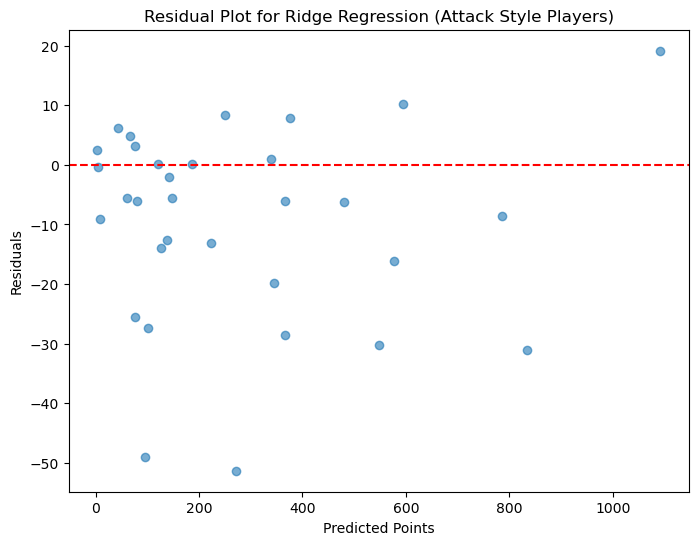

In [1217]:
# Residual Plot helps identify patterns in the model's prediction errors
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Points')
    plt.ylabel('Residuals')
    plt.show()

# Create a residual plot for Ridge Regression (Attack Style Players)
plot_residuals(attack_results_df['Actual Points'], attack_results_df['Predicted Points'], 'Ridge Regression (Attack Style Players)')


#### Obervations
* There is no clear pattern or trend. This indicates that the model isn't systematically biased in over- or under-predicting across different predicted values.
* The variability of the residuals seems to increase with the magnitude of predicted points, which may suggest that the model's accuracy decreases for higher predicted values.
* A few significant outliers can be seen, with residuals at or below -50.  Further investigation of outliers is a good next step.
* Most residuals are scattered around the zero line, which is generally good, because it suggests that the model is not consistently over or under predicting for most players. 

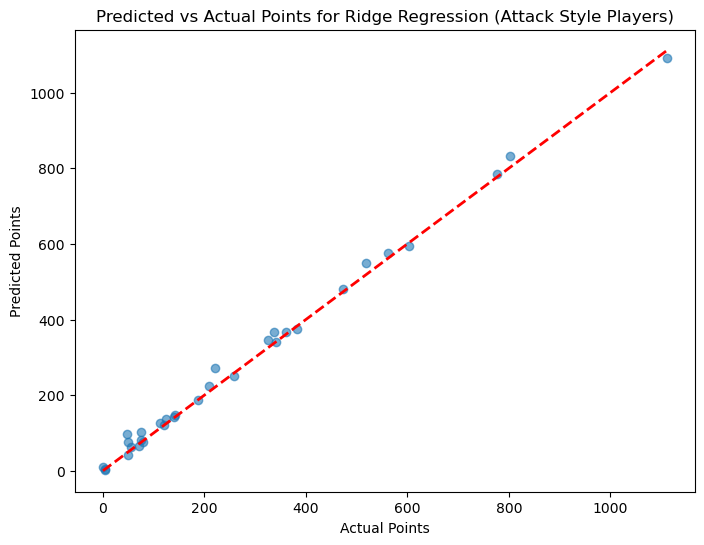

In [1218]:
# Predicted vs. Actual Scatter Plot shows the relationship between the actual and predicted values.
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(f'Predicted vs Actual Points for {model_name}')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')
    plt.show()

# Create a predicted vs. actual plot for Ridge Regression (Attack Style Players)
plot_predicted_vs_actual(attack_results_df['Actual Points'], attack_results_df['Predicted Points'], 'Ridge Regression (Attack Style Players)')


#### Obersvations
* The points are clustered closely around the diagonal red dashed line (which represents perfect predictions where predicted values equal actual values).
* As we move to higher actual points (towards 800-1000), there is some spread in the predicted values, though the deviations are still small.
* The model’s accuracy slightly decreases for higher-scoring players, which we saw in the last visual.
* Unlike the last visual, this plot doesn’t show any significant outliers.

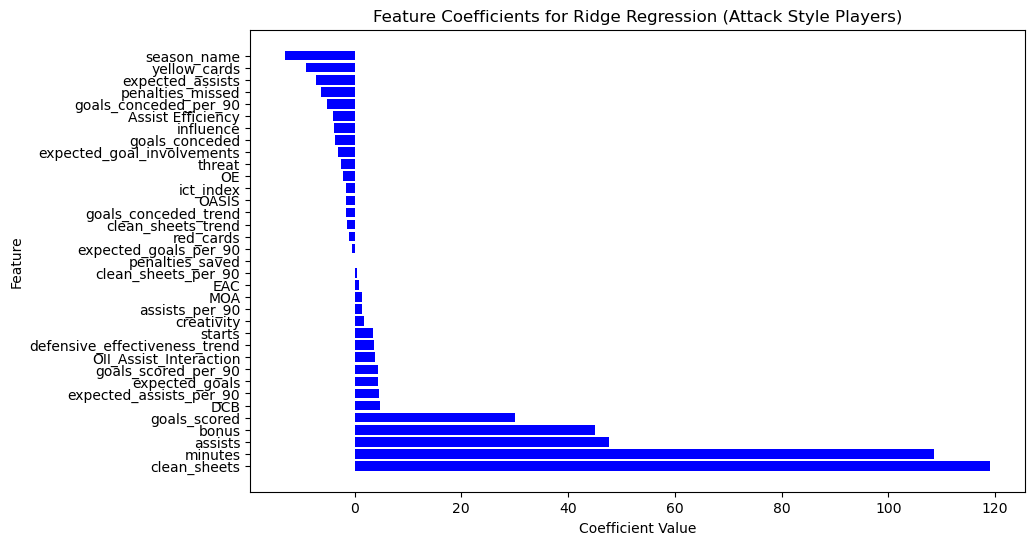

In [1219]:
def plot_feature_coefficients(model, X_train, model_name):
    # Directly access the coefficients from the model
    coefficients = model.coef_
    features = X_train.columns
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
    plt.title(f'Feature Coefficients for {model_name}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

# Assuming the Ridge model is already trained as 'ridge_model_attack'
plot_feature_coefficients(ridge_model_attack, X_train_attack, 'Ridge Regression (Attack Style Players)')


#### Obersvations
The coefficients indicate how much each feature contributes to the prediction.
* Key drivers include: Clean Sheets, Minutes and Assists, which are the most important.
* Many features, including some suprising ones, have very small or zero coefficients: Yellow Cards, Expected Assists, Penalties Missed, and Goals Conceded per 90. 

### Visuals -- Stopping Style

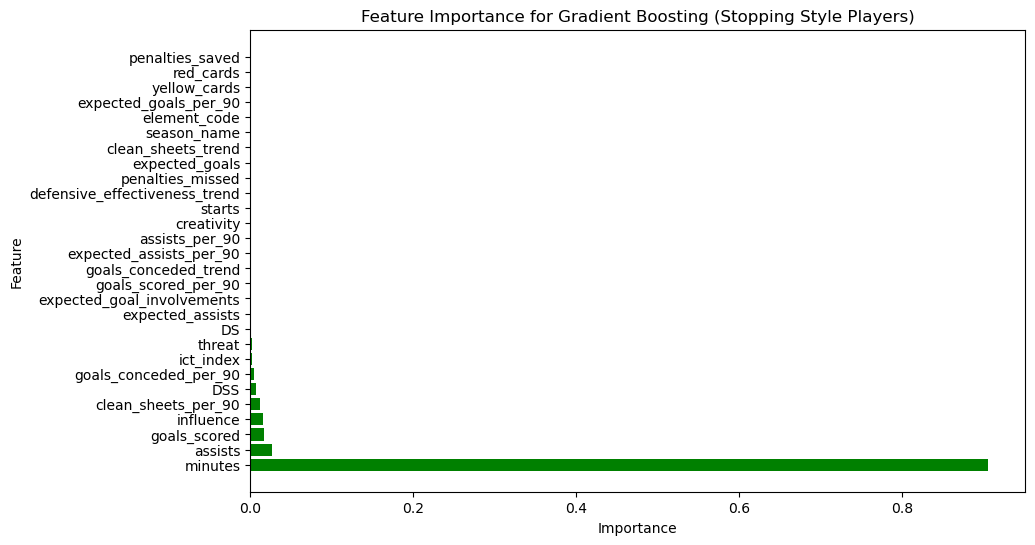

In [1220]:
# Define the pipeline with Gradient Boosting Regressor and access it from the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Train the pipeline on stopping style players
pipeline.fit(X_train_stopping, y_train_stopping)

# Extract the Gradient Boosting model from the pipeline
gb_model_stopping = pipeline.named_steps['model']

# Plot feature importance for the Gradient Boosting model
plot_feature_importance(gb_model_stopping, X_train_stopping, 'Gradient Boosting (Stopping Style Players)')


#### Oberservations
* Minutes played is by far the most important feature.
* Interestingly, Assists and Goals Scored also play an important role, but are weighted in feature engineering for the Attack model where as they are not in the Stopping model.  For next steps it would be interesting to use a culstering model to suss out styles of play and use PCA to understand feature signifigance.
*  A large number of features, such as Penalties Saved, Red Cards, Expected Assists per 90, and Expected Goals per 90, have near-zero importance!
* Minutes, Assists, and Goals Scored dominate, with the remaining defensive metrics contributing far less to the model.

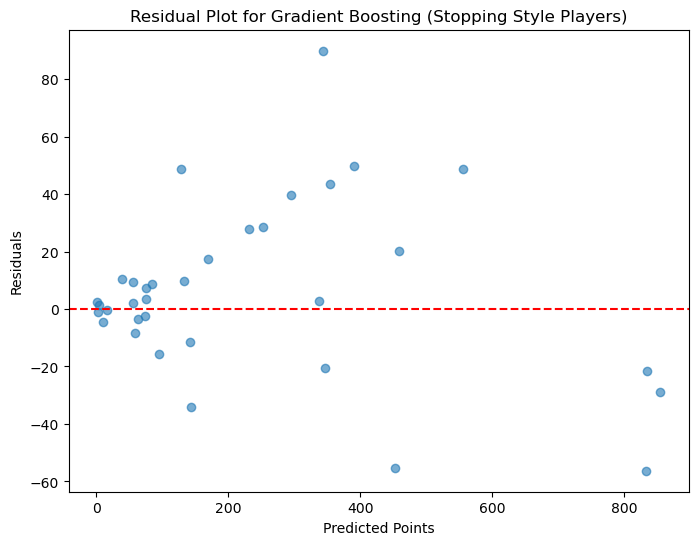

In [1221]:
# Residual Plot selps to identify any patterns or systematic errors in the predictions.
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Points')
    plt.ylabel('Residuals')
    plt.show()

# Generate predictions for the holdout set using the trained pipeline
y_pred_gb_stopping = pipeline.predict(X_holdout_stopping)

# Plot residuals for Gradient Boosting (Stopping Style Players)
plot_residuals(y_holdout_stopping, y_pred_gb_stopping, 'Gradient Boosting (Stopping Style Players)')


#### Observations:
* Ideally, residuals should be randomly scattered around the horizontal line at 0. In this plot, while some residuals are close to zero, there is a noticeable spread, especially for higher predicted points (above ~200). This indicates that the model struggles to accurately predict points for some players, particularly those with higher predicted points.
* There are some outliers where the residuals are significantly different from zero (e.g., residuals greater than 60 and less than -50). These points indicate that the model is making large errors in some cases.


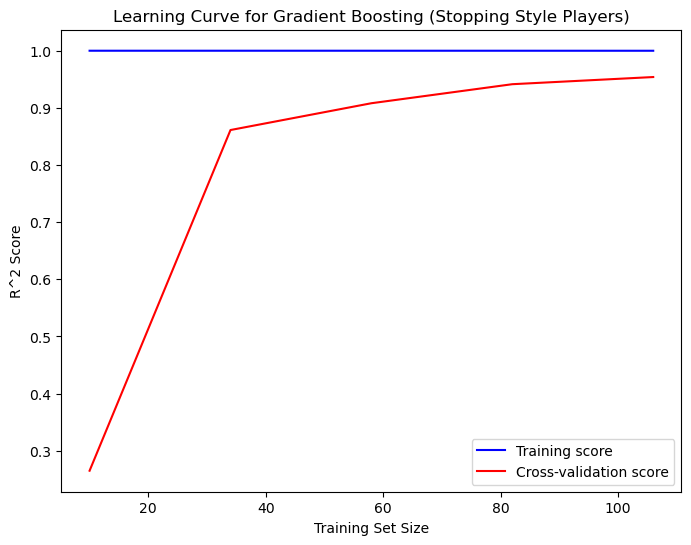

In [1222]:
# Learning Curve helps diagnose if the model is underfitting or overfitting 
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1)
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('R^2 Score')
    plt.legend(loc='best')
    plt.show()

# Assuming you have the Gradient Boosting model
plot_learning_curve(GradientBoostingRegressor(random_state=42), X_train_stopping, y_train_stopping, 'Gradient Boosting (Stopping Style Players)')


#### Observations
1. Training Score (Blue Line)
    * The training score remains constant at 1.0 across all training set sizes, which means that the model perfectly fits the training data. This is indicative of overfitting :(
2. Cross-Validation Score (Red Line)
    * At around 40 samples, the cross-validation score stabilizes above 0.9, and as the training set size continues to increase, the cross-validation score increases slightly. This is a very good cross-validation score, suggesting the model performs well on unseen data :/
3. Methinks...
    * Overfitting.
    * The model is likely way too complex.

### Match-up defenders with their Id's and photos

In [1223]:
defenders_features_df.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,ict_index_per_90,discrepancy_expected_actual_goals,goals_conceded_rolling_5,clean_sheets_rolling_5,yellow_cards_rolling_5,red_cards_rolling_5,defensive_effectiveness_rolling_5,defensive_effectiveness_trend,goals_conceded_trend,clean_sheets_trend
0,2016,17761,40,40,23,568,0,0,1,11,...,4.357394,-11.0,11.000000,1.000000,1.000000,0.0,-0.633803,NaN,NaN,NaN
1,2017,17761,45,46,101,2790,0,1,11,30,...,3.800000,-30.0,20.500000,6.000000,3.000000,0.0,-0.439482,0.194321,9.500000,5.000000
2,2018,17761,50,47,97,3086,3,2,7,63,...,4.505833,-63.0,34.666667,6.333333,4.666667,0.0,-0.510746,-0.071264,14.166667,0.333333
3,2019,17761,50,55,143,3420,2,3,15,50,...,3.944737,-50.0,38.500000,8.500000,6.000000,0.0,-0.475165,0.035581,3.833333,2.166667
4,2020,17761,55,53,109,3240,1,0,11,50,...,3.547222,-50.0,40.800000,9.000000,6.000000,0.0,-0.466798,0.008366,2.300000,0.500000


### Add a file that links the player to their id and/or photo